In [0]:
'''
Script - Do Not Modify

Running this cell will install all the libraries that can be used to solve this
week's Lab. You can make use of any of these libraries to help you in your code.
'''


from google.colab import files
from io import BytesIO
from PIL import Image
import cv2
import numpy as np
import scipy
from scipy import signal
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# If you get an error regarding the release version of albumentations, Ignore it.

In [0]:
'''
Helper Function - Do Not Modify
You can use this function in your code
'''

def matrixABC(sparse_control_points, elements):
  """
  Get the triangle matrix given three endpoint sets
  [[ax bx cx]
    [ay by cy]
    [1   1  1]]

  Input - 
  sparse_control_points - sparse control points for the input image
  elements - elements (Each Simplex) of Tri.simplices

  Output - 
  Stack of all [[ax bx cx]
                [ay by cy]
                [1   1  1]]
  """
  output = np.zeros((3, 3))

  # First two rows using Ax Ay Bx By Cx Cy
  for i, element in enumerate(elements):
      output[0:2, i] = sparse_control_points[element, :]

  # Fill last row with 1s
  output[2, :] = 1
  
  return output

In [0]:
'''
Helper Function - Do Not Modify
You can use this helper function in generate_warp
'''

def interp2(v, xq, yq):
	
	dim_input = 1
	if len(xq.shape) == 2 or len(yq.shape) == 2:
		dim_input = 2
		q_h = xq.shape[0]
		q_w = xq.shape[1]
		xq = xq.flatten()
		yq = yq.flatten()

	h = v.shape[0]
	w = v.shape[1]
	if xq.shape != yq.shape:
		raise('query coordinates Xq Yq should have same shape')

	x_floor = np.floor(xq).astype(np.int32)
	y_floor = np.floor(yq).astype(np.int32)
	x_ceil = np.ceil(xq).astype(np.int32)
	y_ceil = np.ceil(yq).astype(np.int32)

	x_floor[x_floor < 0] = 0
	y_floor[y_floor < 0] = 0
	x_ceil[x_ceil < 0] = 0
	y_ceil[y_ceil < 0] = 0

	x_floor[x_floor >= w-1] = w-1
	y_floor[y_floor >= h-1] = h-1
	x_ceil[x_ceil >= w-1] = w-1
	y_ceil[y_ceil >= h-1] = h-1

	v1 = v[y_floor, x_floor]
	v2 = v[y_floor, x_ceil]
	v3 = v[y_ceil, x_floor]
	v4 = v[y_ceil, x_ceil]

	lh = yq - y_floor
	lw = xq - x_floor
	hh = 1 - lh
	hw = 1 - lw

	w1 = hh * hw
	w2 = hh * lw
	w3 = lh * hw
	w4 = lh * lw

	interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

	if dim_input == 2:
		return interp_val.reshape(q_h, q_w)
	return interp_val

In [0]:
'''
Function - Modify
'''

def generate_warp(size_H, size_W, Tri, A_Inter_inv_set, A_im_set, image):

    # Generate x,y meshgrid

    # IMPLEMENT HERE
    x, y = np.meshgrid(np.arange(size_W), np.arange(size_H))

    # Flatten the meshgrid
    
    # IMPLEMENT HERE
    x = x.flatten()
    y = y.flatten()

    # Zip the flattened x, y and Find Simplices (hint: use list and zip)

    # IMPLEMENT HERE
    pts = np.array(list(zip(x, y)))
    idx = Tri.find_simplex(pts)

    # compute alpha, beta, gamma for all the color layers(3)
    
    # IMPLEMENT HERE
    A_inv = A_Inter_inv_set[idx]
    p_x = pts[:, 0]
    p_y = pts[:, 1]
    alpha = A_inv[:, 0, 0] * p_x + A_inv[:, 0, 1] * p_y + A_inv[:, 0, 2]
    beta  = A_inv[:, 1, 0] * p_x + A_inv[:, 1, 1] * p_y + A_inv[:, 1, 2]
    gamma = A_inv[:, 2, 0] * p_x + A_inv[:, 2, 1] * p_y + A_inv[:, 2, 2]

    # Find all x and y co-ordinates

    # IMPLEMENT HERE
    A_im = A_im_set[idx]
    all_x_coor = A_im[:, 0, 0] * alpha + A_im[:, 0, 1] * beta + A_im[:, 0, 2] * gamma
    all_y_coor = A_im[:, 1, 0] * alpha + A_im[:, 1, 1] * beta + A_im[:, 1, 2] * gamma
    all_z_coor = np.ones(beta.size)

    # Divide all x and y with z

    # IMPLEMENT HERE
    all_x_coor_d = all_x_coor / all_z_coor
    all_y_coor_d = all_y_coor / all_z_coor

    # Generate Warped Images (Use function interp2) for each of 3 layers
    generated_pic = np.zeros((size_H, size_W, 3), dtype=np.uint8)

    # IMPLEMENT HERE
    for i in range(3):
      generated_pic_temp = interp2(image[:, :, i], all_x_coor_d, all_y_coor_d)
      generated_pic[:, :, i] = np.reshape(generated_pic_temp, (size_H, size_W))

    return generated_pic

In [0]:
'''
Function - Do Not Modify
'''

def ImageMorphingTriangulation(im1, im2, im1_pts, im2_pts, warp_frac,dissolve_frac):
  """
  INPUT 
  im1: H×W×3 numpy array representing the first image.
  im2: H×W×3 matrix representing the second image.
  im1_pts: N×2 matrix representing correspondences in the first image.
  im2_pts: N×2 matrix representing correspondences in the second image.
  warp_frac: 1×M vector representing each frame’s shape warping parameter.
  dissolve_frac: 1×M vector representing each frame’s cross-dissolve parameter.

  OUTPUT
  H×W×3 numpy array representing the morphed image

  Tips: Read about Delaunay function from scipy.spatial and see how you could
  use it here
  """

  # Compute the H,W of the images (same size)
  size_H = im1.shape[0]
  size_W = im1.shape[1]
  
  # Find the coordinates of the intermediate points
  intermediate_coords = (1 - warp_frac)*im1_pts + warp_frac*im2_pts
  
   # Generate Triangulation for the intermediate points (Use Delaunay function)
  Tri = Delaunay(intermediate_coords)
  nTri = Tri.simplices.shape[0] 

  # Initialize the Triangle Matrices for all the triangles in image
  ABC_Inter_inv_set = np.zeros((nTri, 3, 3))
  ABC_im1_set = np.zeros((nTri, 3, 3))
  ABC_im2_set = np.zeros((nTri, 3, 3))

  # Fill the Triangle Matries
  for ii, element in enumerate(Tri.simplices):
    ABC_Inter_inv_set[ii, :, :] = np.linalg.inv(matrixABC(intermediate_coords, element))
    ABC_im1_set[ii, :, :] = matrixABC(im1_pts, element)
    ABC_im2_set[ii, :, :] = matrixABC(im2_pts, element)

  # Generate warp pictures (Use generate warp from the previous block)
  warp_im1 = generate_warp(size_H, size_W, Tri, ABC_Inter_inv_set, ABC_im1_set, im1)
  warp_im2 = generate_warp(size_H, size_W, Tri, ABC_Inter_inv_set, ABC_im2_set, im2)

  # Cross Dissolve 
  dissolved_pic = (1 - dissolve_frac) * warp_im1 + dissolve_frac * warp_im2
  dissolved_pic = dissolved_pic.astype(np.uint8)
      
  # Saving each and every image to the folder
  imgs = Image.fromarray(dissolved_pic, 'RGB')
  imgs.save('face_morph.png')
  
  files.download('face_morph.png')
  return dissolved_pic  

In [6]:
'''
Script - Do Not Modify the script. 

This script will run the image loader where you need to select the images and 
points.mat from your local disk. 
'''

uploaded = files.upload()
face1 = Image.open(BytesIO(uploaded['a.png']))
face2 = Image.open(BytesIO(uploaded['c.png']))

im1 = np.array(face1)
im2 = np.array(face2)

import scipy.io
mat = scipy.io.loadmat('points.mat')
im1_pts = mat['Ip'] - 1
im2_pts = mat['Jp'] - 1

Saving a.png to a.png
Saving c.png to c.png
Saving points.mat to points.mat


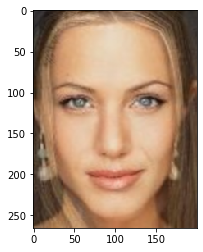

In [7]:
'''
Script - Do Not Modify (You can change the values for warp_frac and 
dissolve_frac)
This script will run the Image Morphing Triangulation Function.
'''
warp_frac = 1/2
dissolve_frac = 1/2
res = ImageMorphingTriangulation(im1, im2, im1_pts, im2_pts, warp_frac,dissolve_frac)
plt.imshow(res)
plt.show()